In [160]:
import fastai
from fastai.vision.all import *
import os

In [161]:
def es_correcta(imagen): return imagen[8] == 'B'

In [162]:
path = Path('/home/yani/TFG-Dataset/DatasetConIncorrectas/Tipo3/Completo/')
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.3, bs=9, seed=43,
    label_func=es_correcta
)

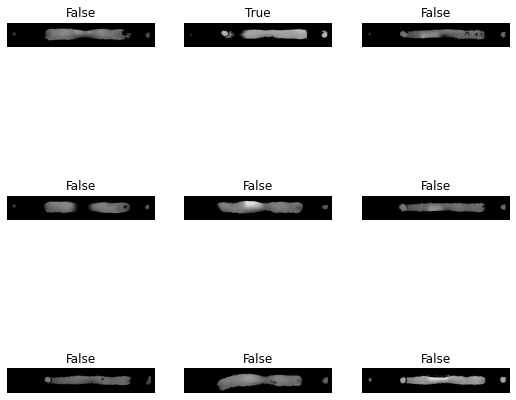

In [163]:
dls.show_batch()

In [184]:
#conv_kwargs = {'kernel_size' : 3, 'padding': 1, 'padding_mode': 'reflect', 'bias': False}
conv_kwargs = {'kernel_size' : 3,'padding':1, 'bias': False}

Las ResNet usan el diseño usado por las VGGs de usar un kernel de tamaño 3x3 que es lo que hacemos aqui.

https://d2l.ai/chapter_convolutional-modern/resnet.html

In [165]:
path=Path('/home/yani/TFG-Dataset/DatasetConIncorrectas/Tipo3/Completo/CompletoBDia_1_Pieza_15_Soldadura_77.png')

In [166]:
from PIL import Image
import numpy
import torchvision
import matplotlib.pyplot as plt

imagen = Image.open(path)
imagen = tensor(imagen)
print(imagen.shape)
# trans = torchvision.transforms.ToTensor()
# imagen = trans(imagen)
# print(imagen.shape)


torch.Size([80, 480])


El shape del tensor es ([canales, alto, ancho])

In [167]:
xb, yb = dls.one_batch()
print(f'Entrada: {xb.shape}, Salida:{yb.shape}')

Entrada: torch.Size([9, 3, 80, 480]), Salida:torch.Size([9])


In [186]:
inp_stem = nn.Sequential(nn.Conv2d(3, 32, stride=2, **conv_kwargs),
                        nn.BatchNorm2d(32),
                        nn.ReLU(),
                        nn.Conv2d(32, 32, stride=1, **conv_kwargs),
                        nn.BatchNorm2d(32),
                        nn.ReLU(),
                        nn.Conv2d(32, 64, stride=1, **conv_kwargs),
                        nn.BatchNorm2d(64),
                        nn.ReLU(),
                        )

torch.Size([9, 64, 40, 240])


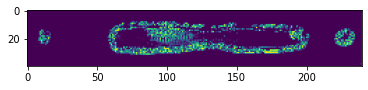

In [187]:
xb = xb.to(device='cpu')
#feature = inp_stem(imagen)
feature = inp_stem(xb)
print(feature.shape)
feature = feature[0][0]
a_imagen = torchvision.transforms.ToPILImage()

feature = a_imagen(feature)

plt.imshow(feature)

### En este punto creamos la clase para los bloques residuales.

In [212]:
class ResidualBlock(nn.Module):
    def __init__(self, canales_entrada, canales_salida, stride=1):
        super().__init__()
        self.canales_entrada = canales_entrada
        self.canales_salida = canales_salida
        #self.stride = stride
        self.id = []
        self.operaciones = nn.Sequential(
            nn.Conv2d(canales_entrada, canales_salida, stride=stride, **conv_kwargs),
            nn.BatchNorm2d(canales_salida),
            nn.ReLU(),
            nn.Conv2d(canales_salida, canales_salida, stride=stride, **conv_kwargs),
            nn.BatchNorm2d(canales_salida)
        )
        
        if canales_entrada != canales_salida:
            self.id.extend([nn.Conv2d(canales_entrada, canales_salida,
                                      kernel_size=1, padding=0, bias=False),
                           nn.BatchNorm2d(canales_salida)])
        self.id = nn.Sequential(*self.id)
    def forward(self, entrada):
        return nn.ReLU()(self.operaciones(entrada) + self.id(entrada))

En este caso se ha usado la siguiente estructura para crear el bloque residual. En caso de que el numero de canales de entrada no coincidan con los de salida usamos una convolucion 1x1 para ajustar

<img src="https://d2l.ai/_images/resnet-block.svg" alt="drawing" width="500"/>



torch.Size([9, 64, 40, 240])
torch.Size([9, 128, 40, 240])


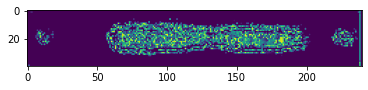

In [213]:

entrada_bloque = inp_stem(xb)
print(entrada_bloque.shape)

res = ResidualBlock(canales_entrada=64, canales_salida=128)
salida_bloque = res.forward(entrada_bloque)

print(salida_bloque.shape)
salida_bloque = a_imagen(salida_bloque[0][0])

plt.imshow(salida_bloque)